In [4]:
   
def demo_coherent_signals(M = 2, d=0.25):
    """
     Description:
     ------------
         Basic demonstration for the forward-backward averaging.         
    
        Parameters:
        -----------          
            M     : (int) Number of antenna elements in the antenna array. Default value: 4
            d     : (float) Distance between antenna elements. [lambda] Default value: 0.5
    """
    
    N = 2**10  # sample size          
    theta_list=[50]   # Incident angles of test signal   
       
    # Generate multichannel test signal 
    soi = np.random.normal(0,1,N)   # Signal of Interest        
    
    soi_matrix  = np.zeros((M,N), dtype=complex)    

    for p in range(len(theta_list)):        
        a = np.exp(np.arange(0,M,1)*1j*2*np.pi*d*np.cos(np.deg2rad(theta_list[p])))    
        soi_matrix  += (np.outer( soi, a)).T 
    
    # Generate multichannel uncorrelated noise
    noise = np.random.normal(0,np.sqrt(10**-3),(M,N))
    
    # Create received signal
    rec_signal = soi_matrix + noise
    
    ## R matrix calculation
    R = corr_matrix_estimate(rec_signal.T, imp="mem_eff")
    
    R = forward_backward_avg(R)
    
    # Generate scanning vectors        
    array_alignment = np.arange(0, M, 1) * d
    incident_angles= np.arange(0,181,1)
    ula_scanning_vectors = gen_ula_scanning_vectors(array_alignment, incident_angles)
    
    # DOA estimation
    Bartlett = DOA_Bartlett(R, ula_scanning_vectors)    
    Capon = DOA_Capon(R, ula_scanning_vectors)
    MEM = DOA_MEM(R, ula_scanning_vectors,  column_select = 0)
    LPM = DOA_LPM(R, ula_scanning_vectors, element_select = 1)
    MUSIC = DOA_MUSIC(R, ula_scanning_vectors, signal_dimension = 2)
    
    # Plot results
    axes = plt.axes()
    DOA_plot(Bartlett, incident_angles, log_scale_min = -50, axes=axes)
    DOA_plot(Capon, incident_angles, log_scale_min = -50, axes=axes)
    DOA_plot(MEM, incident_angles, log_scale_min = -50,axes=axes)
    DOA_plot(LPM, incident_angles, log_scale_min = -50, axes=axes)
    DOA_plot(MUSIC, incident_angles, log_scale_min = -50, axes=axes)
    axes.legend(("Bartlett","Capon","MEM","LPM","MUSIC"))
    # Mark nominal incident angles
    for p in range(len(theta_list)):
        axes.axvline(linestyle = '--',linewidth = 2,color = 'black',x = theta_list[p])
    #axes.axvline(linestyle = '--',linewidth = 2,color = 'black',x = 115)

/home/rafael/.local/lib/python3.6/site-packages/pyargus/directionEstimation.py:389: RuntimeWarning: divide by zero encountered in true_divide
  ADORT[theta_index]=  1/np.abs(S_theta_.getH()*(E*E.getH())*S_theta_)
/home/rafael/.local/lib/python3.6/site-packages/pyargus/directionEstimation.py:883: RuntimeWarning: invalid value encountered in true_divide
  DOA_data = np.divide(np.abs(DOA_data),np.max(np.abs(DOA_data))) # normalization


Minimum alias angle 0.00 
Maximum alias angle 0.00 
Minimum alias angle 0.00 
Maximum alias angle 0.00 
Minimum alias angle 0.00 
Maximum alias angle 0.00 
Minimum alias angle 0.00 
Maximum alias angle 0.00 
Minimum alias angle 0.00 
Maximum alias angle 0.00 


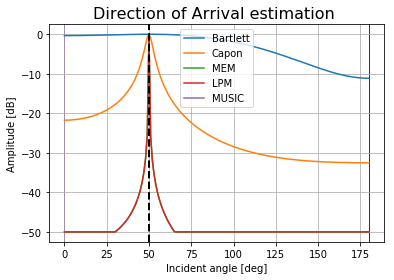

In [5]:
demo_coherent_signals()

In [ ]:
################################PATA############################

In [2]:
import numpy as np
from pyargus.directionEstimation import *

In [3]:
#setup de sincronização
def hilbert_of_complex(signal):
    signal_real = real(signal)
    signal_imag = imag(signal)
    signal_real_ = hilbert(signal_real)
    signal_imag_ = hilbert(signal_imag)
    hilbert_signal = signal_real_ + signal_imag_*1j
    
    return signal + hilbert_signal*1j
 
def cross_corr(y1, y2):

    if len(y1) != len(y2):
        raise ValueError('Inputs com len diferentes')

    y1_auto_corr = np.dot(y1, y1) / len(y1)
    y2_auto_corr = np.dot(y2, y2) / len(y1)
    corr = np.correlate(y1, y2, mode='same')
    unbiased_sample_size = np.correlate(
      np.ones(len(y1)), np.ones(len(y1)), mode='same')
    corr = corr / unbiased_sample_size / np.sqrt(y1_auto_corr * y2_auto_corr)
    shift = len(y1) // 2

    max_corr = np.max(corr)
    argmax_corr = np.argmax(corr)
    return argmax_corr - shift

def sincroniza_sinal(lag,signal1,signal2):
    k1 = signal2[abs(lag):]
    k2 = signal1[:len(k1)]
    return k1,k2

def lag_GCCphat(signal1,signal2):
    N=2*len(signal1)
    X1aux=scipy.fft(signal1,N)
    X2aux=scipy.fft(signal2,N)
    r12=np.real(scipy.fft.fftshift(scipy.fft.ifft(X1aux*np.conj(X2aux)/(1e-6+abs(X1aux*X2aux)))))
    return int(np.argmax(r12) - len(r12)/2)

#def read_file_IQ(dire):
#    data = open(dire, 'rb').read()
#    integer_data = [int(i) - 128 for i in data]
#    signal = [complex(a,b) for a,b in zip(integer_data[0::2], integer_data[1::2])]
#    return signal

def read_file_IQ(dire):
    samples = np.fromfile(dire, np.complex64)
    return samples


#a principio só com a primeira parte de sinc

dire_sinal1 = "/home/rafael/DoA/sinalL.bin"
sinal1 = read_file_IQ(dire_sinal1)

dire_sinal2 = "/home/rafael/DoA/sinalR.bin"
sinal2 = read_file_IQ(dire_sinal2)

samples_sinc_interval = int(len(sinal1)/3)

#######lag de defasagem######

lag = cross_corr(sinal1[:samples_sinc_interval],sinal2[:samples_sinc_interval])
#lag = lag_GCCphat(sinal1[:samples_sinc_interval],sinal2[:samples_sinc_interval])

sinal_real1 = sinal1[samples_sinc_interval:2*samples_sinc_interval]
sinal_real2 = sinal2[samples_sinc_interval:2*samples_sinc_interval]

sinal_real1, sinal_real2 = sincroniza_sinal(lag, sinal_real2, sinal_real1)


In [4]:
import numpy as np
from scipy.signal import butter, lfilter, freqz, hilbert
import matplotlib.pyplot as plt
from pylab import *
from rtlsdr import *
from scipy import *

In [5]:
b, a = butter(10, 0.2, btype='lowpass', analog=False)
sinal_real1_filtrado = lfilter(b, a, sinal_real1)
sinal_real2_filtrado = lfilter(b, a, sinal_real2)

In [10]:
sinal_real1_sem_nan = []
for sample in sinal_real2:
    if (math.isnan(np.imag(sample)) or math.isnan(np.real(sample))):
        continue
    else:
        sinal_real1_sem_nan.append(sample)                                  

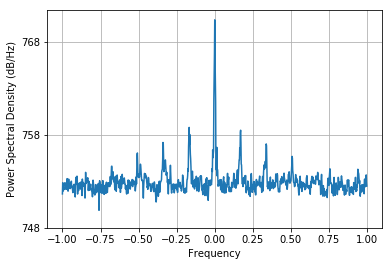

In [13]:
plt.psd(sinal_real1_sem_nan, NFFT = 1024)
plt.show()

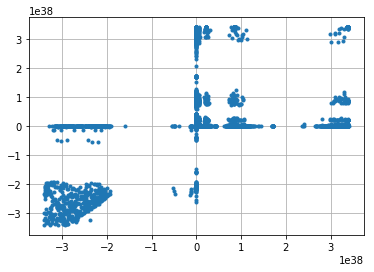

In [8]:
plt.plot(np.real(sinal_real2_sem_nan), np.imag(sinal_real2_sem_nan), '.')
plt.grid(True)
plt.show()

In [94]:
#setar infos
M = 2
d = 0.2533

rec_signal = np.array([sinal_real1_filtrado, sinal_real2_filtrado])

rec_signal = rec_signal - np.mean(rec_signal)

R = corr_matrix_estimate(rec_signal.T, imp="mem_eff")

R = forward_backward_avg(R)

# Generate scanning vectors        
array_alignment = np.arange(0, M, 1) * d
incident_angles= np.arange(0,181,1)
ula_scanning_vectors = gen_ula_scanning_vectors(array_alignment, incident_angles)

# DOA estimation
Bartlett = DOA_Bartlett(R, ula_scanning_vectors)    
Capon = DOA_Capon(R, ula_scanning_vectors)
MEM = DOA_MEM(R, ula_scanning_vectors,  column_select = 0)
LPM = DOA_LPM(R, ula_scanning_vectors, element_select = 1)
MUSIC = DOA_MUSIC(R, ula_scanning_vectors, signal_dimension = 2)

# Plot results
axes = plt.axes()
DOA_plot(Bartlett, incident_angles, log_scale_min = -50, axes=axes)
DOA_plot(Capon, incident_angles, log_scale_min = -50, axes=axes)
DOA_plot(MEM, incident_angles, log_scale_min = -50,axes=axes)
DOA_plot(LPM, incident_angles, log_scale_min = -50, axes=axes)
DOA_plot(MUSIC, incident_angles, log_scale_min = -50, axes=axes)
axes.legend(("Bartlett","Capon","MEM","LPM","MUSIC"))
# Mark nominal incident angles

LinAlgError: Array must not contain infs or NaNs

In [4]:
import matplotlib.pyplot as plt
import scipy
import numpy as np
from pyargus.directionEstimation import *


def cross_corr(y1, y2):

    if len(y1) != len(y2):
        raise ValueError('Inputs com len diferentes')

    y1_auto_corr = np.dot(y1, y1) / len(y1)
    y2_auto_corr = np.dot(y2, y2) / len(y1)
    corr = np.correlate(y1, y2, mode='same')
    # The unbiased sample size is N - lag.
    unbiased_sample_size = np.correlate(
      np.ones(len(y1)), np.ones(len(y1)), mode='same')
    corr = corr / unbiased_sample_size / np.sqrt(y1_auto_corr * y2_auto_corr)
    shift = len(y1) // 2

    max_corr = np.max(corr)
    argmax_corr = np.argmax(corr)
    return argmax_corr - shift

def sincroniza_sinal(lag,signal1,signal2):
    k1 = signal2[abs(lag):]
    k2 = signal1[:len(k1)]
    return k1,k2

def lag_GCCphat(signal1,signal2):
    N=2*len(signal1)
    X1aux=scipy.fft(signal1,N)
    X2aux=scipy.fft(signal2,N)
    r12=np.real(scipy.fft.fftshift(scipy.fft.ifft(X1aux*np.conj(X2aux)/(1e-6+abs(X1aux*X2aux)))))
    return int(np.argmax(r12) - len(r12)/2), r12

def read_file_IQ(dire):
    data = open(dire, 'rb').read()
    integer_data = [int(i) - 128 for i in data]
    signal = [complex(a,b) for a,b in zip(integer_data[0::2], integer_data[1::2])]
    return signal


In [ ]:
x = np.linspace(0, 2*np.pi, 10000)
sen = np.sin(x)
cos = np.cos(x)
plt.plot(x,sen)
plt.plot(x,cos)

In [ ]:
lag = cross_corr(sen,cos)

In [ ]:
lag

In [ ]:
sen,cos = sincroniza_sinal(lag,cos,sen)

In [ ]:
plt.plot(x[:len(sen)],sen)
plt.plot(x[:len(sen)],cos)

In [ ]:
x = np.linspace(0, 2*np.pi, 10000)
sen = np.sin(x)
cos = np.cos(x)
plt.plot(x,sen)
plt.plot(x,cos)

In [ ]:
lag, r12 = lag_GCCphat(sen,cos)

In [ ]:
sen,cos = sincroniza_sinal(lag,cos,sen)

In [ ]:
plt.plot(x[:len(sen)],sen)
plt.plot(x[:len(sen)],cos)

In [ ]:
#############read file.iq##############

[-6.2639694e+29          +nanj            nan-3.1369635e+38j
            nan-2.0336848e+38j ... -3.0736360e-01+9.4662533e+33j
  5.1435596e+03-5.4309605e-14j -4.1283112e-18+8.8470104e+30j]


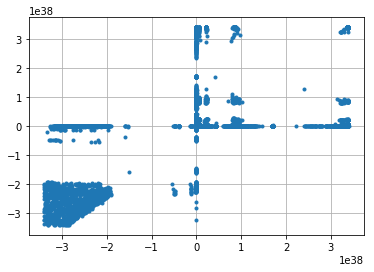

In [32]:
import numpy as np
import matplotlib.pyplot as plt

samples = np.fromfile("/home/rafael/DoA/sinalL.bin", np.complex64) # Read in file.  We have to tell it what format it is
print(samples)

# Plot constellation to make sure it looks right
plt.plot(np.real(samples), np.imag(samples), '.')
plt.grid(True)
plt.show()

[-0.94054108+0.01477652j -1.08701297-0.08965063j -1.11592626+0.13332774j
 ...  1.07161938-0.17463015j  0.94567029+0.05859098j
 -0.97181537+0.01884162j]


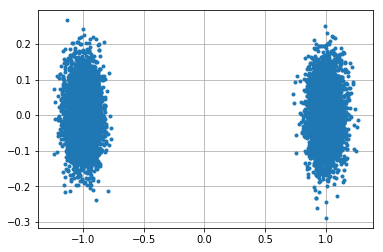

<class 'numpy.complex128'>
<class 'numpy.complex64'>


In [7]:
import numpy as np
import matplotlib.pyplot as plt

num_symbols = 10000

x_symbols = np.random.randint(0, 2, num_symbols)*2-1 # -1 and 1's
n = (np.random.randn(num_symbols) + 1j*np.random.randn(num_symbols))/np.sqrt(2) # AWGN with unity power
r = x_symbols + n * np.sqrt(0.01) # noise power of 0.01
print(r)
plt.plot(np.real(r), np.imag(r), '.')
plt.grid(True)
plt.show()

# Now save to an IQ file
print(type(r[0])) # Check data type.  Ooops it's 128 not 64!
r = r.astype(np.complex64) # Convert to 64
print(type(r[0])) # Verify it's 64
r.tofile('bpsk_in_noise.iq') # Save to file

[-0.9405411 +0.01477652j -1.087013  -0.08965063j -1.1159263 +0.13332774j
 ...  1.0716194 -0.17463015j  0.9456703 +0.05859099j
 -0.97181535+0.01884162j]


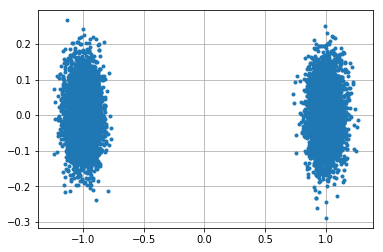

In [8]:
import numpy as np
import matplotlib.pyplot as plt

samples = np.fromfile('bpsk_in_noise.iq', np.complex64) # Read in file.  We have to tell it what format it is
print(samples)

# Plot constellation to make sure it looks right
plt.plot(np.real(samples), np.imag(samples), '.')
plt.grid(True)
plt.show()